## Testing Playground

In [1]:
import os
print(os.getcwd())
# os.chdir("..")
# os.chdir("dit-editor")
print(os.getcwd())
from data.benchmark_data import gather_images

%load_ext autoreload
%autoreload 2

/home/lsbicego/dit-editor
/home/lsbicego/dit-editor


## Load all benchmark samples along with results we have

In [2]:
# load all benchmark images (around 300)
os_path = "benchmark_images_generations/"
all_images = gather_images(os_path)

Missing images in benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: fg_mask
Skipping benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic: Not all images are present in benchmark_images_generations/Real-Real/0029 a professional photograph of a tomato and strawberries, ultra realistic
Missing images in benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: fg_mask
Skipping benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style: Not all images are present in benchmark_images_generations/Real-Painting/0021 an oil painting of a tomato, Van Gogh Style
Loaded 330 images in benchmark_images_generations/


/home/lsbicego/dit-editor/data/benchmark_data.py:166: UserWarning: Missing 2 images in benchmark_images_generations/
  warnings.warn(f"Missing {missing_image_counter} images in {image_dir}")


Real-Sketch
a pencil drawing of a puppy in the sunset


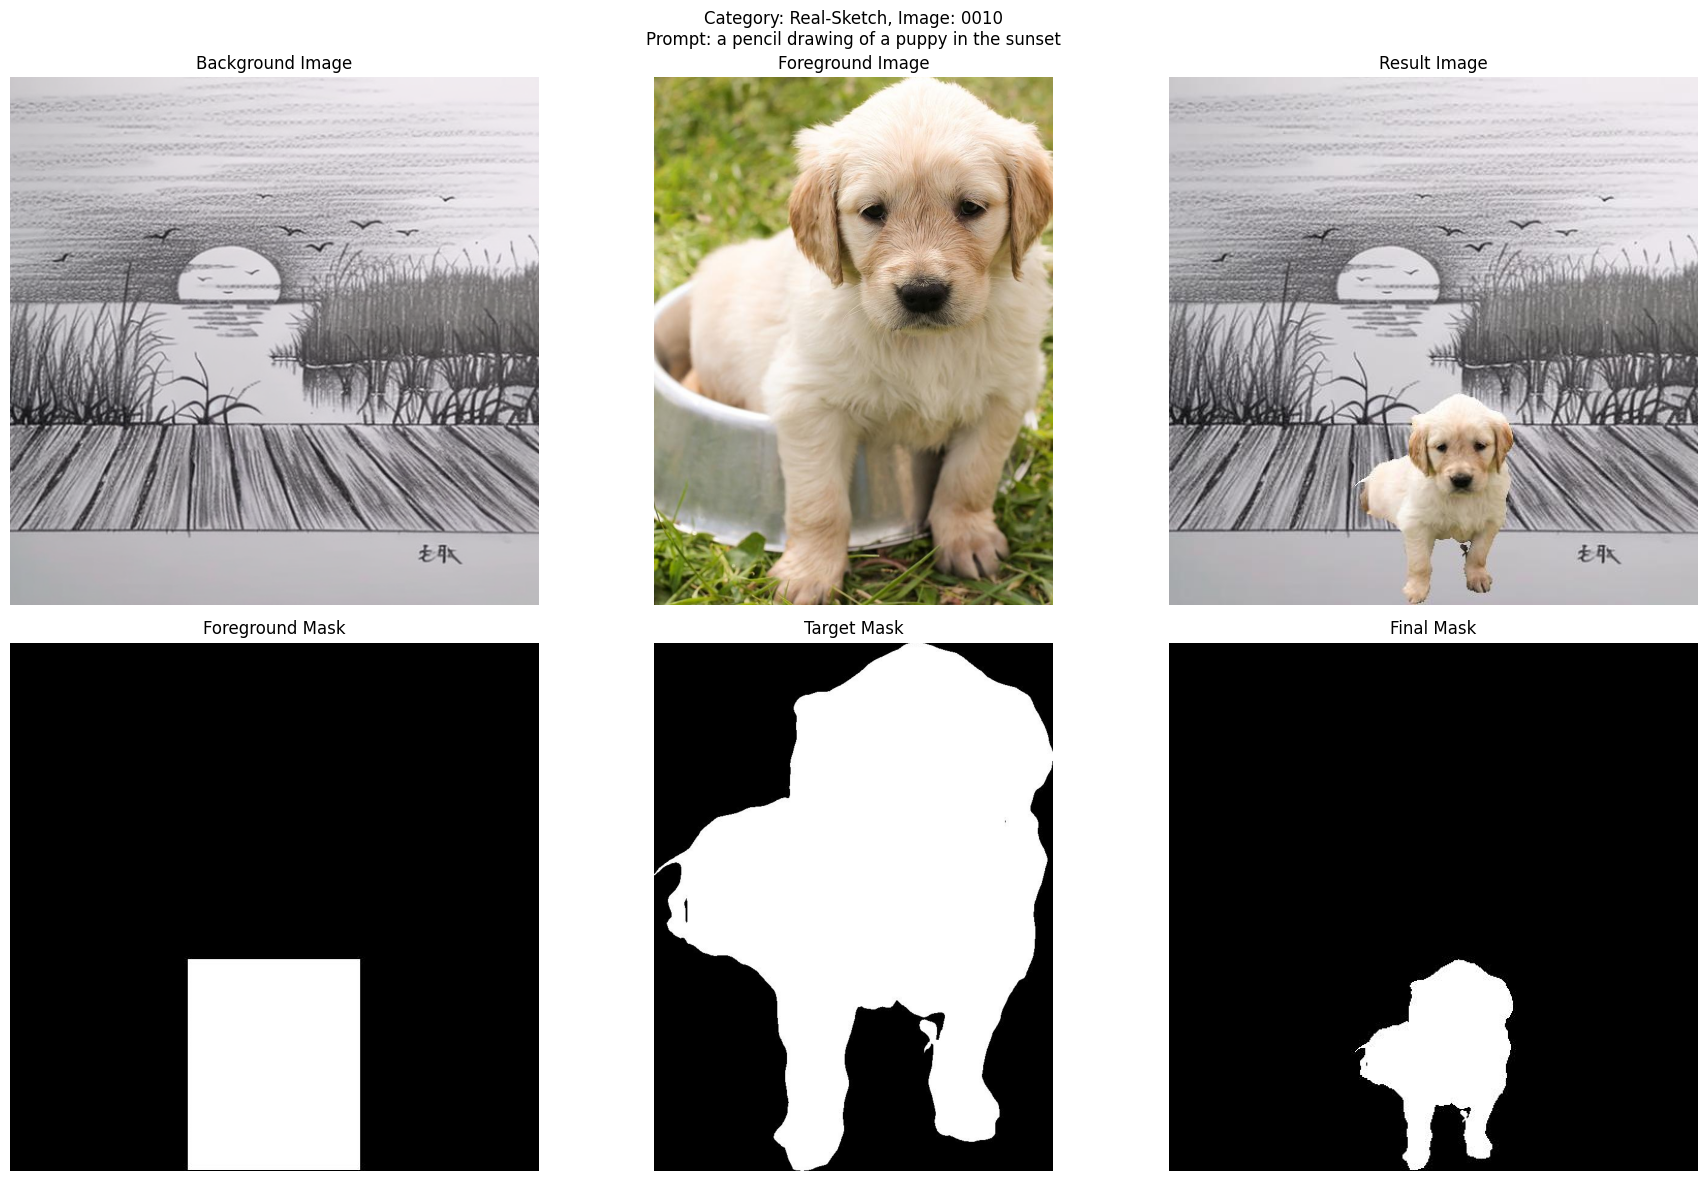

In [7]:
example = all_images[0]
print(example.category)
print(example.prompt)

# Plot the example
example.plot_sample()

## Test and visualise dinov2 foreground similarity

Example category: Real-Sketch
Example prompt: a pencil drawing of a puppy in the sunset
Bounding box of masked region: (176, 304, 336, 512)


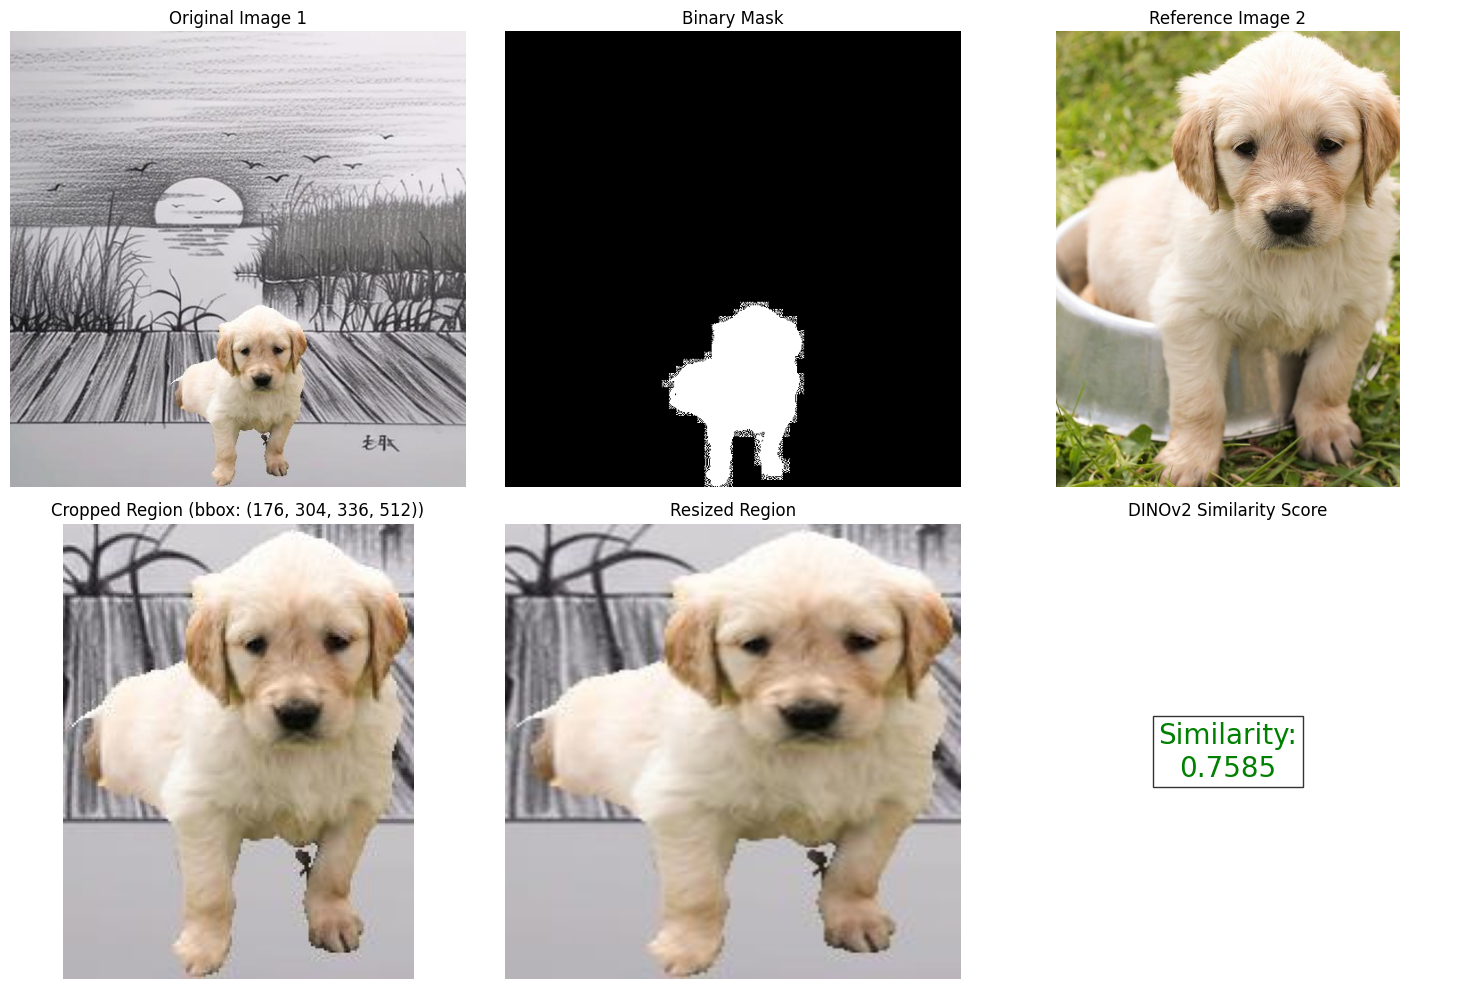

Computed similarity: 0.7585297226905823

Testing with a different example:
Category: Real-Sketch
Prompt: a pencil drawing of a dog in the sunset
Bounding box of masked region: (152, 312, 360, 512)


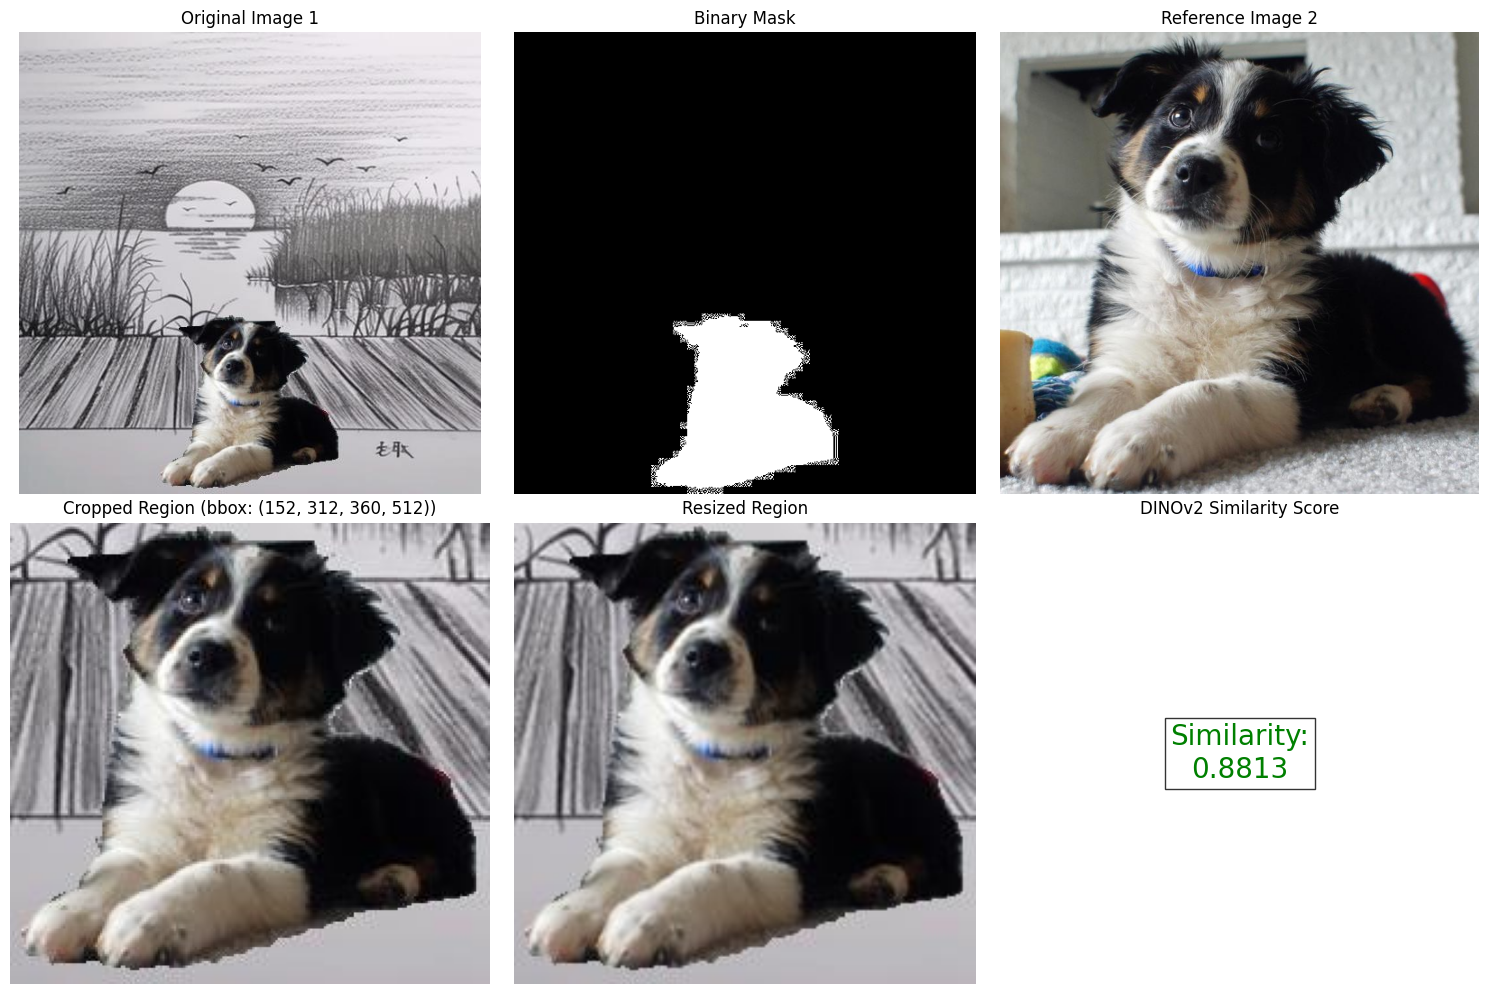

Computed similarity: 0.8813484907150269


In [6]:
from transformers import AutoImageProcessor, AutoModel
import torch
from PIL import Image

import torch.nn.functional as F
import matplotlib.pyplot as plt

# Import necessary libraries that are missing
import torchvision.transforms as T

# Create a function to visualize the intermediate steps
def visualize_dinov2_similarity(
    image1: Image.Image,
    image2: Image.Image,
    mask: Image.Image
) -> float:
    """
    Compute and visualize DINOv2 similarity computation between images
    """
    # Initialize model and processor if not already done
    if not hasattr(compute_dinov2_similarity, "model"):
        compute_dinov2_similarity.processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
        compute_dinov2_similarity.model = AutoModel.from_pretrained("facebook/dinov2-base")
        compute_dinov2_similarity.model.eval()

    processor = compute_dinov2_similarity.processor
    model = compute_dinov2_similarity.model
    
    # Ensure mask is same size as image1
    if mask.size != image1.size:
        print(f"Resizing mask from {mask.size} to match image1 size {image1.size}")
        mask = mask.resize(image1.size, resample=Image.NEAREST)

    # Convert mask to binary and get bounding box of masked region
    mask_binary = mask.convert("L").point(lambda p: p > 0 and 255)
    bbox = mask_binary.getbbox()
    if bbox is None:
        raise ValueError("Mask contains no non-zero region to compare.")
    
    print(f"Bounding box of masked region: {bbox}")
    
    # Crop the masked region and resize back to original size
    region = image1.crop(bbox)
    resized_region = region.resize(image1.size, resample=Image.BILINEAR)

    # Prepare images for model
    img1_rgb = resized_region.convert("RGB")
    img2_rgb = image2.convert("RGB")

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Original images and mask
    axes[0, 0].imshow(image1)
    axes[0, 0].set_title("Original Image 1")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask_binary, cmap='gray')
    axes[0, 1].set_title("Binary Mask")
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(image2)
    axes[0, 2].set_title("Reference Image 2")
    axes[0, 2].axis('off')
    
    # Row 2: Visualization of processing steps
    # Show the cropped region
    axes[1, 0].imshow(region)
    axes[1, 0].set_title(f"Cropped Region (bbox: {bbox})")
    axes[1, 0].axis('off')
    
    # Show the resized region
    axes[1, 1].imshow(resized_region)
    axes[1, 1].set_title("Resized Region")
    axes[1, 1].axis('off')
    
    # Compute similarity
    inputs = processor(images=[img1_rgb, img2_rgb], return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
        # Mean-pool token embeddings
        features = outputs.last_hidden_state.mean(dim=1)
        features = F.normalize(features, p=2, dim=-1)
        # Cosine similarity
        similarity = torch.matmul(features[0], features[1]).item()
    
    # Visualize similarity with color indicating strength
    sim_color = 'green' if similarity > 0.7 else 'orange' if similarity > 0.5 else 'red'
    axes[1, 2].text(0.5, 0.5, f"Similarity:\n{similarity:.4f}", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=20, color=sim_color,
                   bbox=dict(facecolor='white', alpha=0.8))
    axes[1, 2].set_title("DINOv2 Similarity Score")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return similarity

# Test with the example
print(f"Example category: {example.category}")
print(f"Example prompt: {example.prompt}")
similarity = visualize_dinov2_similarity(example.result_image, example.fg_image, example.final_mask)
print(f"Computed similarity: {similarity}")

# Compare with a different example
if len(all_images) > 1:
    print("\nTesting with a different example:")
    different_example = all_images[1]
    print(f"Category: {different_example.category}")
    print(f"Prompt: {different_example.prompt}")
    similarity = visualize_dinov2_similarity(different_example.result_image, 
                                           different_example.fg_image, 
                                           different_example.final_mask)
    print(f"Computed similarity: {similarity}")

## Score all samples

In [ ]:
# download aesthetic predictor
!wget https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/refs/heads/main/sac+logos+ava1-l14-linearMSE.pth 

In [ ]:
from evaluation.eval import get_scores_for_single_example
import pandas as pd
from tqdm.notebook import tqdm

num_examples = len(all_images)
all_scores = []

for i, image in tqdm(enumerate(all_images[0:num_examples]), total=num_examples):
    try:
        # Get scores for this example
        example_score_dict = get_scores_for_single_example(image)  # Use image instead of always using all_images[0]
    except Exception as e:
        print(f"Error processing image {i}: {e}")
        continue
    # TODO: handle: operands could not be broadcast together with shapes (256,256,3) (512,512,3)

    # Unpack the nested dictionary
    for model_type, metrics in example_score_dict.items():
        row = {'image_index': i, 'model_type': model_type, "category:": image.category}
        
        # Add all metrics as separate columns
        for metric_name, value in metrics.items():
            # Convert tensor values to float for better display
            if hasattr(value, 'item'):
                value = value.item()
            row[metric_name] = value
            
        all_scores.append(row)

# Create DataFrame from flattened data
df = pd.DataFrame(all_scores)

# Reorder columns to have image_index and model_type first
columns = ['image_index', 'model_type'] + [col for col in df.columns if col not in ['image_index', 'model_type']]
df = df[columns]

df.to_csv("scores.csv", index=False)

df.head()

  0%|          | 0/330 [00:00<?, ?it/s]

Error processing image 0: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 


KeyboardInterrupt: 

In [5]:
from evaluation.eval import calculate_all_scores

# Calculate scores for all benchmark images
df = calculate_all_scores(all_images, output_file="scores.csv")

# Display the first few rows
df.head()

Processing 330 benchmark examples...


  0%|          | 0/330 [00:00<?, ?it/s]

Error processing image 157: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 167: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 174: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 220: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 244: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 248: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 254: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Error processing image 264: operands could not be broadcast together with shapes (256,256,3) (512,512,3) 
Scores saved to scores.csv


image_index model_type     category  hpsv2_score  aesthetics_score  \
0            0  Photoshop  Real-Sketch     0.381118          5.469848   
1            0    TF-ICON  Real-Sketch     0.426673          5.660169   
2            1  Photoshop  Real-Sketch     0.379129          5.508402   
3            1    TF-ICON  Real-Sketch     0.396661          5.580972   
4            2  Photoshop  Real-Sketch     0.323486          5.447720   

   background_mse  clip_text_image  dinov2_similarity  
0        0.000620         0.345759           0.064891  
1        0.008525         0.322444           0.064891  
2        0.003419         0.310391           0.179352  
3        0.011822         0.303254           0.179352  
4        0.000398         0.224001           0.263948

## Preliminary Analysis

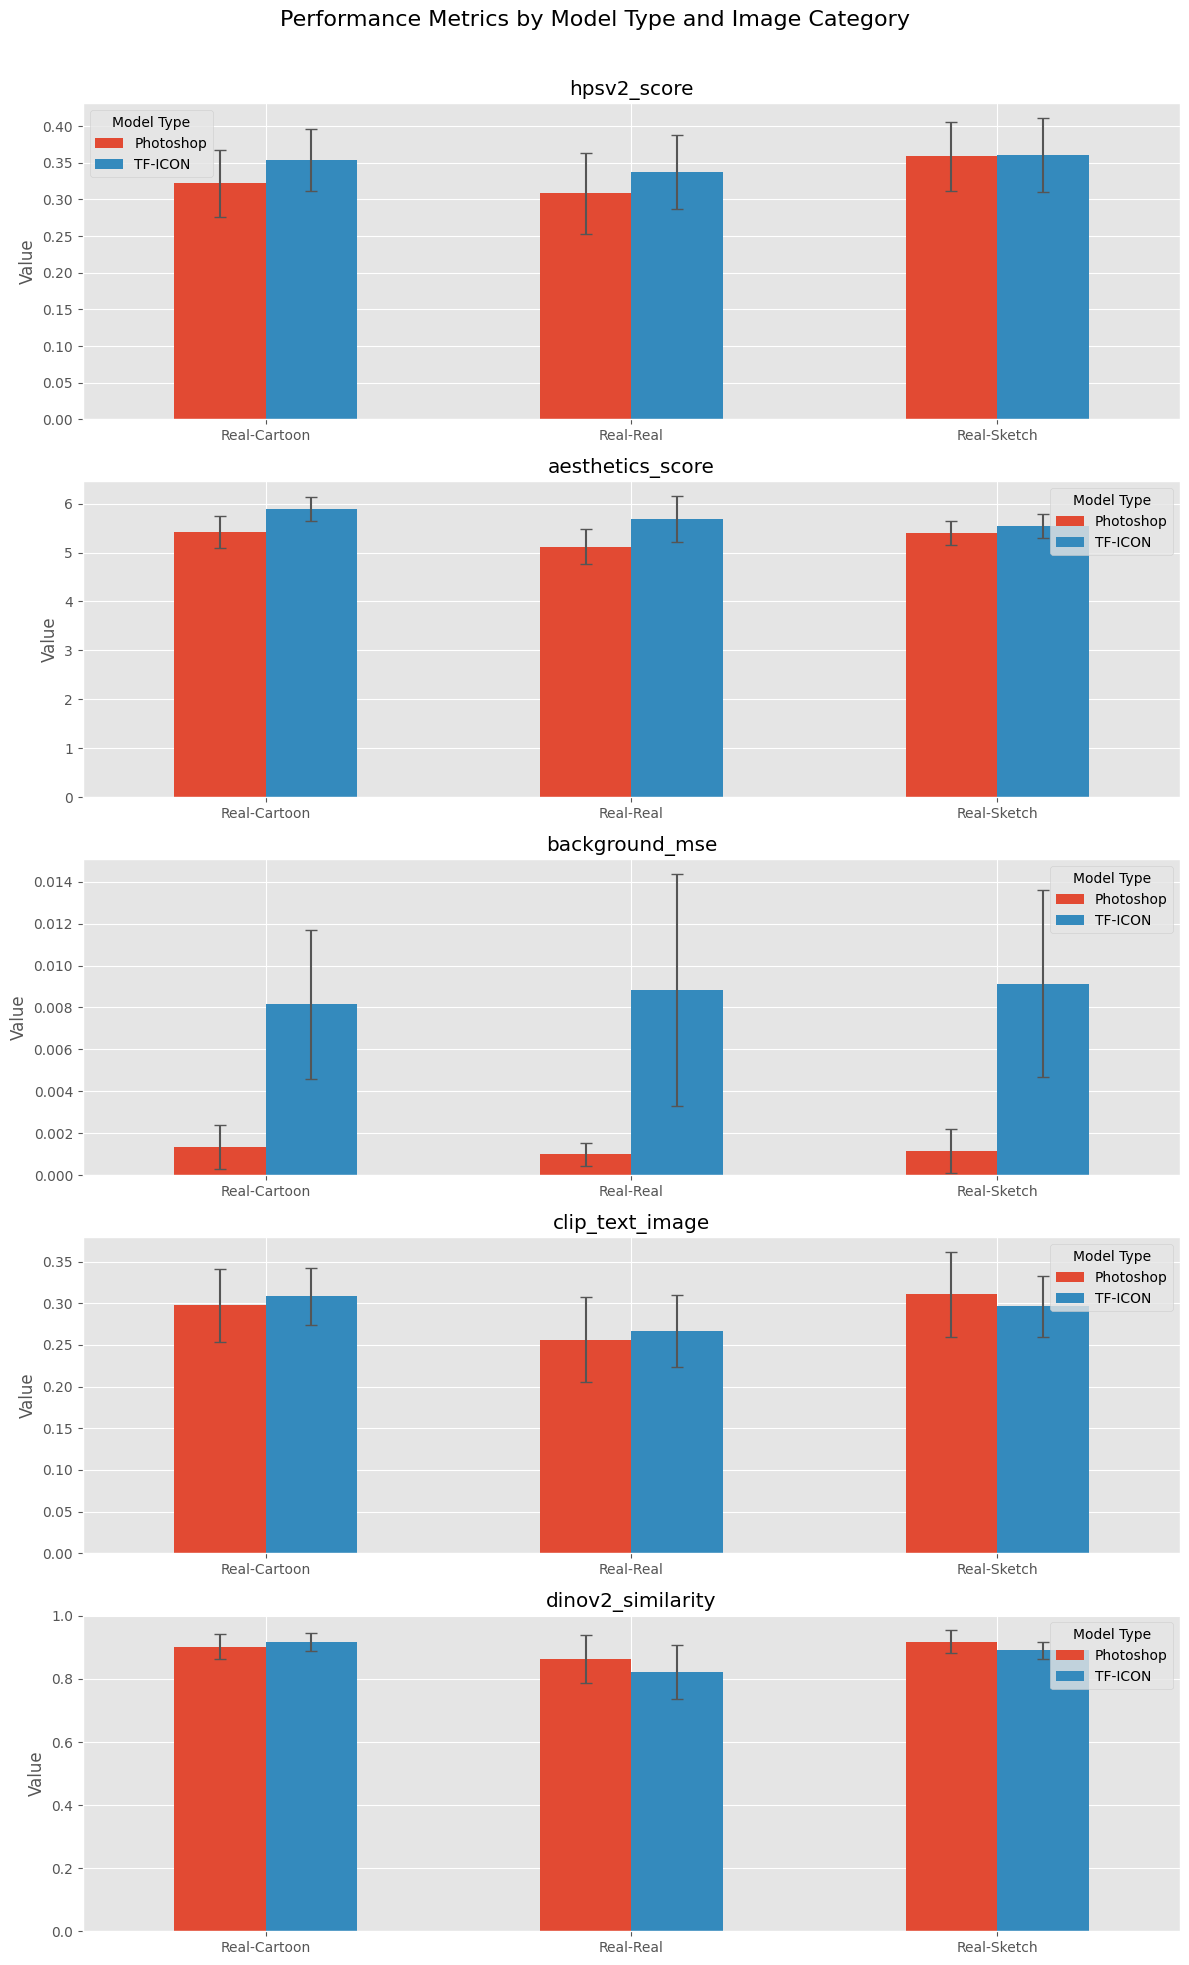

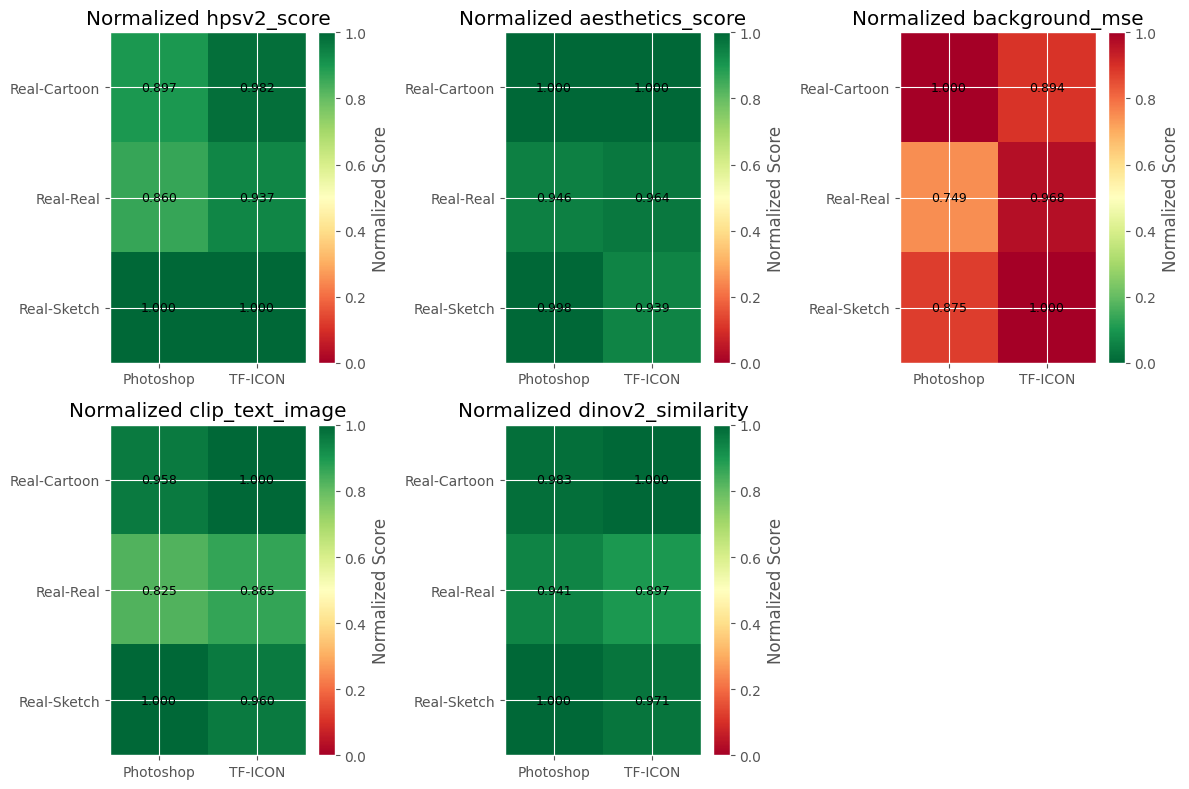

In [23]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Set the style
plt.style.use('ggplot')

# Create a more informative grouped dataframe
metrics = ['hpsv2_score', 'aesthetics_score', 'background_mse', 'clip_text_image', 'dinov2_similarity']

# Group by model_type and category, then calculate mean and std for each metric
result_data = []

for metric in metrics:
    for (model, category), group in df.groupby(['model_type', 'category:']):
        result_data.append({
            'model_type': model,
            'category': category,
            'metric': metric,
            'mean': group[metric].mean(),
            'std': group[metric].std(),
            'count': len(group)
        })

result_df = pd.DataFrame(result_data)

# Create a figure with subplots for each metric
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
fig.suptitle('Performance Metrics by Model Type and Image Category', fontsize=16)

# For each metric, create a grouped bar chart
for i, metric in enumerate(metrics):
    metric_data = result_df[result_df['metric'] == metric]
    
    # Pivot for easier plotting
    pivot_data = metric_data.pivot(index='category', columns='model_type', values='mean')
    
    # Plot bars
    pivot_data.plot(kind='bar', yerr=metric_data.pivot(index='category', 
                                                      columns='model_type', 
                                                      values='std'), 
                   ax=axes[i], capsize=4, rot=0)
    
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel('Value')
    axes[i].set_xlabel('')
    axes[i].legend(title='Model Type')
    

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Also create a heatmap to visualize the relative performance difference
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    
    metric_data = result_df[result_df['metric'] == metric]
    pivot_data = metric_data.pivot(index='category', columns='model_type', values='mean')
    
    # Normalize data for better visualization (except background_mse which is better when lower)
    if metric == 'background_mse':
        # For background_mse, lower is better, so flip the normalization
        pivot_data = pivot_data / pivot_data.max()
        vmin, vmax = 0, 1
        cmap = 'RdYlGn_r'  # Reversed colormap
    else:
        # For other metrics, higher is better
        pivot_data = pivot_data / pivot_data.max()
        vmin, vmax = 0, 1
        cmap = 'RdYlGn'
    # Create a heatmap using matplotlib
    im = plt.imshow(pivot_data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    
    # Add text annotations
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            plt.text(j, i, f'{pivot_data.iloc[i, j]:.3f}', 
                     ha="center", va="center", color="black", fontsize=9)
    
    # Set ticks and labels
    plt.colorbar(im, label='Normalized Score')
    plt.xticks(range(len(pivot_data.columns)), pivot_data.columns)
    plt.yticks(range(len(pivot_data.index)), pivot_data.index)
    plt.title(f'Normalized {metric}')
    plt.tight_layout()

plt.tight_layout()
plt.show()

# DUMP

image_index model_type             metric        value
0               0  Photoshop          category:  Real-Sketch
1               0    TF-ICON          category:  Real-Sketch
2               1  Photoshop          category:  Real-Sketch
3               1    TF-ICON          category:  Real-Sketch
4               2  Photoshop          category:  Real-Sketch
...           ...        ...                ...          ...
1879          154    TF-ICON  dinov2_similarity      0.82135
1880          155  Photoshop  dinov2_similarity     0.867651
1881          155    TF-ICON  dinov2_similarity     0.859105
1882          156  Photoshop  dinov2_similarity     0.850126
1883          156    TF-ICON  dinov2_similarity     0.784594

[1884 rows x 4 columns]

/tmp/2617612/ipykernel_3775777/2081971281.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([groups[model] for model in groups.keys()],


TypeError: the resolved dtypes are not compatible with add.reduce. Resolved (dtype('<U12'), dtype('<U12'), dtype('<U24'))

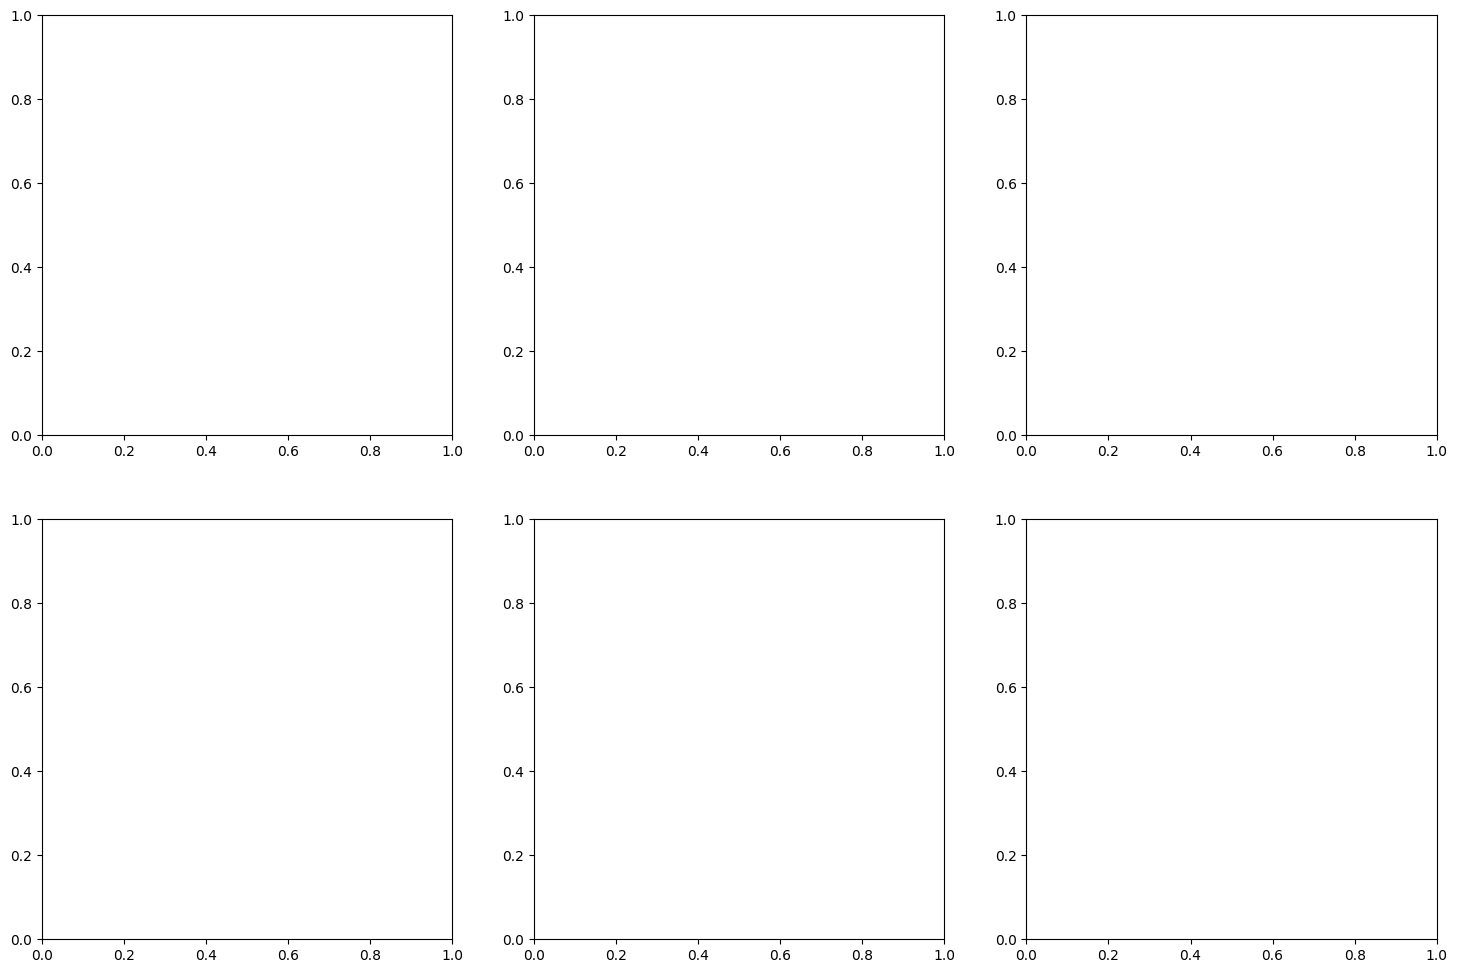

In [22]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


# flatten the DataFrame for easier plotting
df_flat = df.melt(id_vars=['image_index', 'model_type'], var_name='metric', value_name='value')
display(df_flat)


# create barplot with standard deviation in plt
# Set style
plt.style.use('default')

# Get metrics (excluding image_index and model_type)
metrics = df.columns[2:]  # Skip 'image_index' and 'model_type'

# Create figure with subplots for each metric
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Group data by model type
    groups = df.groupby('model_type')[metric].apply(list).to_dict()
    
    # Create boxplot
    bp = ax.boxplot([groups[model] for model in groups.keys()], 
                   patch_artist=True, 
                   labels=list(groups.keys()))
    
    # Add scatter points for individual data
    for j, model in enumerate(groups.keys()):
        # Add jitter to x-positions for better visibility
        x = [j+1 + (np.random.random()-0.5)*0.3 for _ in range(len(groups[model]))]
        ax.scatter(x, groups[model], alpha=0.5, s=20, color='black')
    
    # Customize boxplot colors
    colors = ['lightblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{metric} by Model Type')
    ax.set_xlabel('Model Type')
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove unused subplot if necessary
if len(metrics) < len(axes):
    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Create summary table with mean and standard deviation for each metric by model type
summary_data = []
for metric in metrics:
    for model in df['model_type'].unique():
        mean_val = df[df['model_type'] == model][metric].mean()
        std_val = df[df['model_type'] == model][metric].std()
        summary_data.append({
            'metric': metric,
            'model_type': model,
            'mean': mean_val,
            'std': std_val,
            'formatted': f"{mean_val:.4f} ± {std_val:.4f}"
        })

summary_df = pd.DataFrame(summary_data)
summary_pivot = summary_df.pivot(index='metric', columns='model_type', values='formatted')
display(summary_pivot)

In [14]:
# summarise across model type and image category,
# calculate mean and std and also plot it
# Group by model type and image category, then calculate mean and std

grouped_df = df.groupby(['model_type', 'category:']).agg(['mean', 'std']).reset_index()
grouped_df.columns = ['model_type', 'category:', 'mean', 'std']
grouped_df['formatted'] = grouped_df.apply(lambda row: f"{row['mean']:.4f} ± {row['std']:.4f}", axis=1)
grouped_df = grouped_df.pivot(index='category:', columns='model_type', values='formatted')
display(grouped_df)
# Plot the grouped data
fig, ax = plt.subplots(figsize=(12, 6))
grouped_df.plot(kind='bar', ax=ax)
ax.set_title('Mean and Standard Deviation of Metrics by Model Type and Image Category')
ax.set_ylabel('Metric Value')
ax.set_xlabel('Image Category')
plt.xticks(rotation=45)
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()
# Save the grouped DataFrame to CSV
grouped_df.to_csv("grouped_scores.csv", index=True)
# Save the summary DataFrame to CSV
summary_df.to_csv("summary_scores.csv", index=False)



ValueError: Length mismatch: Expected axis has 14 elements, new values have 4 elements

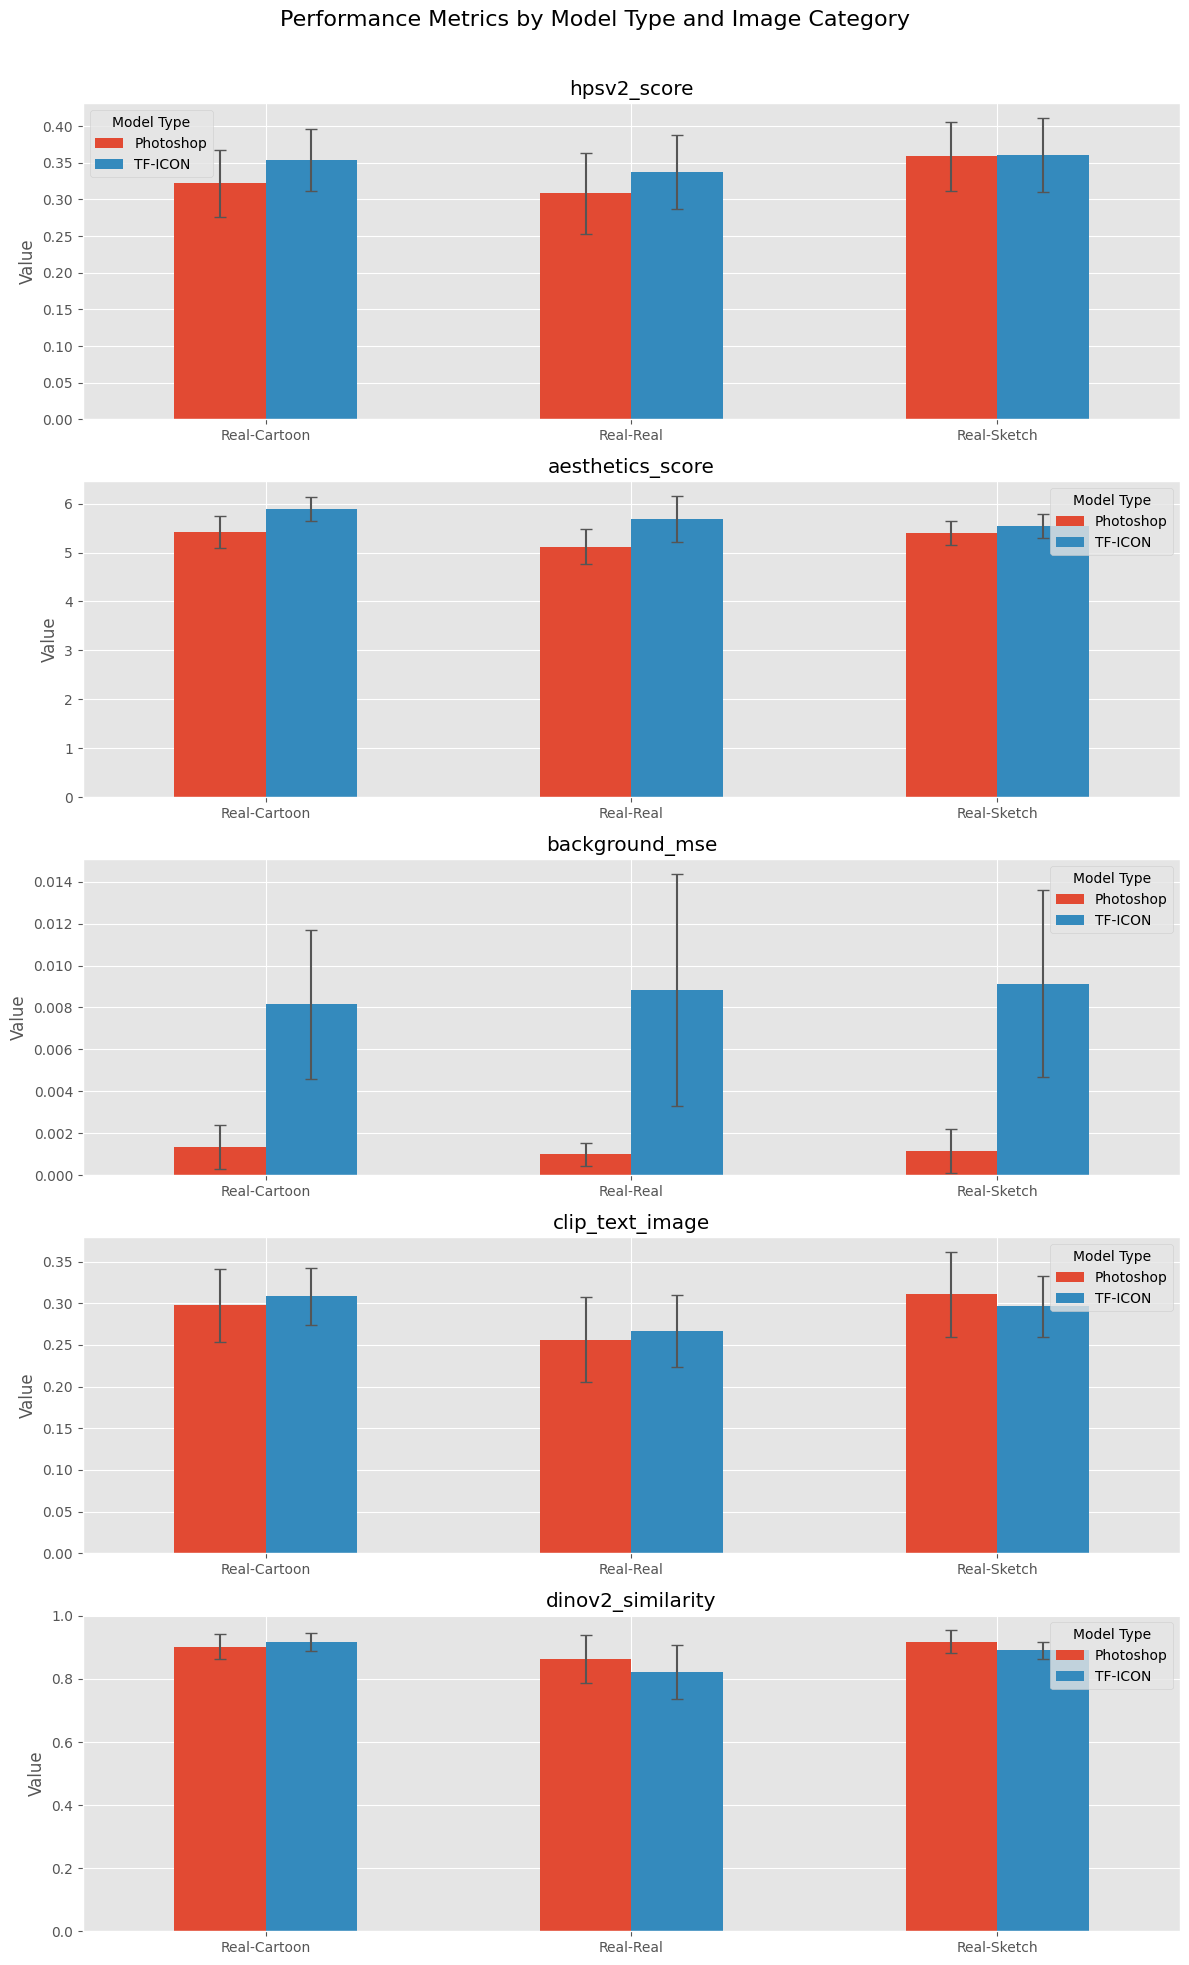

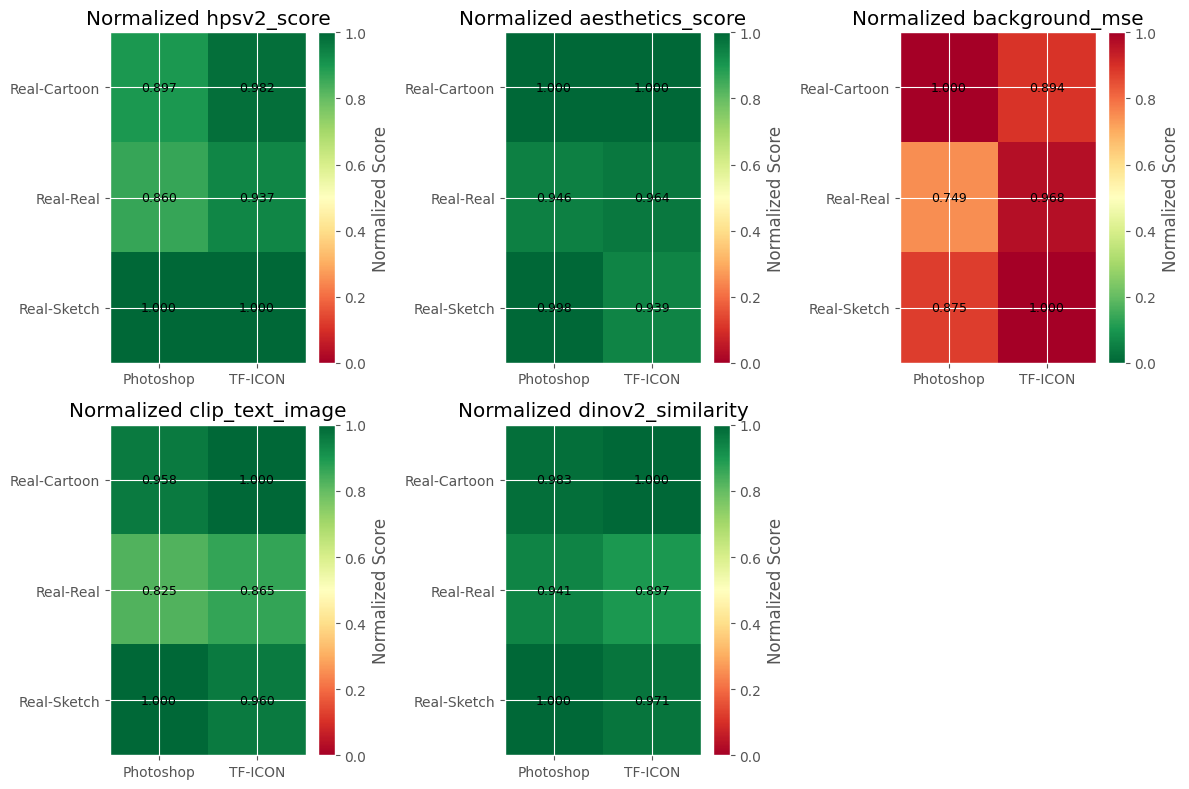

In [ ]:
df.groupby(["model_type", "image_category"]).aggregate("mean", "std")

In [15]:
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 85.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


Real-Cartoon
a cartoon animation of a hamburger, a croissant, a piece of bread and a cup of coffee


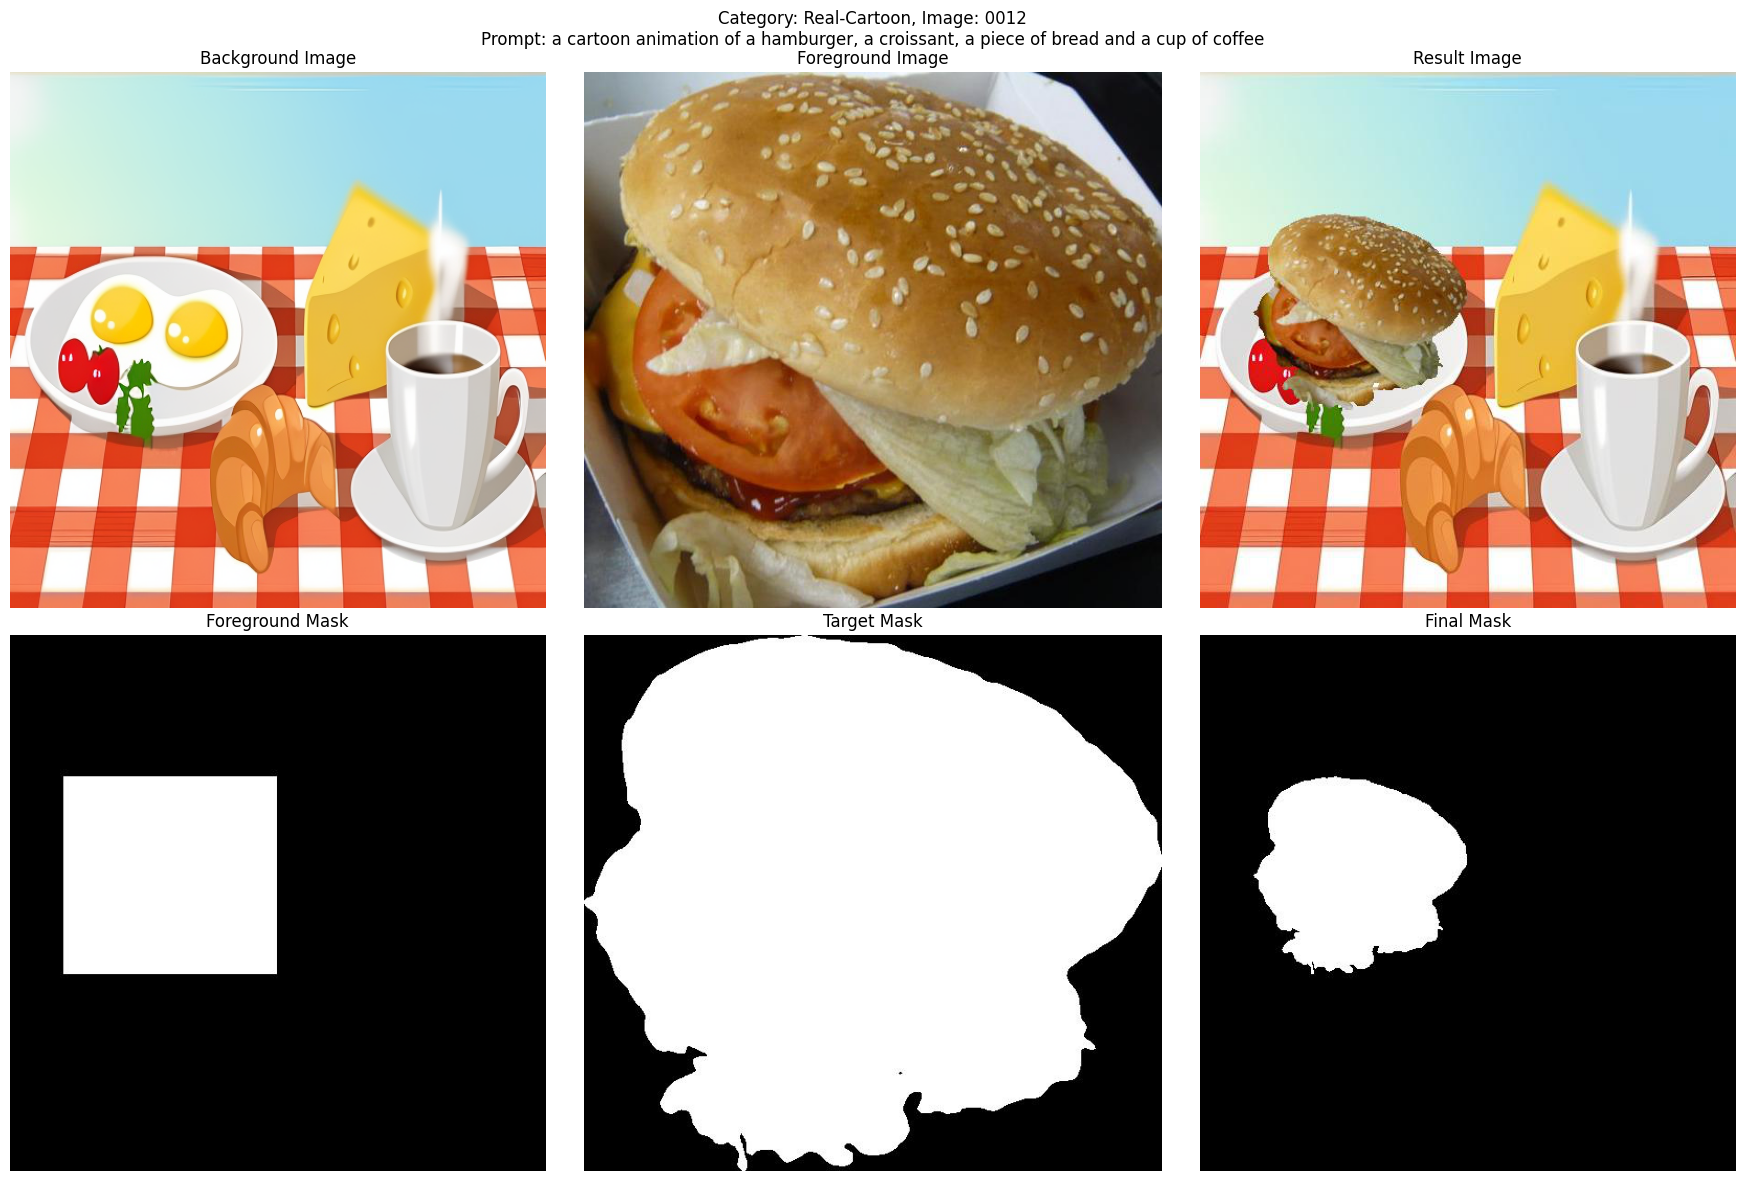